### Mandelbrot
This notebook demonstrates the use of a loop in TF. Note that in the [TensorFlow documentation](https://www.tensorflow.org/versions/r0.11/tutorials/mandelbrot/index.html) and [here](../simple_ops/Mandelbrot.ipynb) there are a alternative approaches which uses assignments `tf.assign` and `tf.assign_add` to update variables in the graph from python. 

### Definition of the Mandelbrot set
Remember the 80ies! z is a complex number. We consider the recursive relation 

$$
      z_{n+1} = z^2_{n} + c \text{   with   } Z_0 = 0      
$$

Now consider several numbers c, like $c=0 + 0 \cdot i$ if above recursion diverges, then c is part of the Mandelbrot set. 

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [2]:
#  Preparing the grid
Y, X = np.mgrid[-1.3:1.3:0.005, -2:1:0.005]
C_ = np.asarray(X+1j*Y, dtype='complex64')
Z_ = np.zeros_like(C_)
C_.shape

(520, 600)

#### Loops
[Loops](https://www.tensorflow.org/versions/r0.11/api_docs/python/control_flow_ops.html#while_loop) can be defined as:

```
    tf.while_loop(cond, body, loop_vars, ...)
```
Note that one can backpropagate (in TF calculate the symbolic grapdient) through loops. To use a loop you have to define 2 functions and have a loop variable. Let's make first a simple example:

In [3]:
def cond(i):
    return tf.less(i, 10)

def body(i):
    # Complicated stuff, depending on i
    return i + 1

tf.reset_default_graph()
i = tf.Variable(1.0, name = 'iterator')

loop = tf.while_loop(cond, body, [i], name='my_while_loop')

# Does not look too good
tf.train.SummaryWriter("/tmp/dumm/loop", tf.get_default_graph(), 'graph.pbtxt')

with tf.Session() as sess:
    tf.initialize_all_variables().run()
    print(sess.run(i, ))
    print(sess.run(loop))

1.0
10.0


#### Loops may not have side effects

The problem is that in a TensorFlow loop the `body` and `cond` function are not allowed to have side effects. I assume that this meanes that all variables have to be present locally. I guess this is due to the fact, that the loops might run on different devices and thus needs to get all they need locally. See also http://stackoverflow.com/questions/37571017/tensorflow-stuck-into-endless-loop-using-tf-while-loop/37573208#37573208

In [4]:
#  Preparing the grid
Y, X = np.mgrid[-1.3:1.3:0.005, -2:1:0.005]
C_ = np.asarray(X+1j*Y, dtype='complex64')
Z_ = np.zeros_like(C_)
C_.shape

(520, 600)

In [5]:
tf.reset_default_graph()
# Would be great if there was a naming convention C_
C = tf.placeholder(shape=C_.shape, dtype='complex64')
Z = tf.Variable(tf.zeros(C_.shape, dtype='complex64'), name='Z')

def cond(i, Z, C):
    return tf.less(i, 200)

def body(i, Z, C):
    Z = Z*Z + C
    return [i + 1, Z, C]

i = tf.Variable(0, name='counter')
loop = tf.while_loop(cond, body, [i, Z, C])

init = tf.initialize_all_variables()
# The Graph looks a bit messy
writer = tf.train.SummaryWriter("/tmp/dumm/mandelbrot_loop", tf.get_default_graph(), 'graph.pbtxt').close()
with tf.Session() as sess:
    sess.run(init)
    start = time.time()
    i, Z_out, C_out = sess.run(loop, {C:C_})
    print('Total time {} msec'.format(time.time() - start))

Total time 0.240833997726 msec


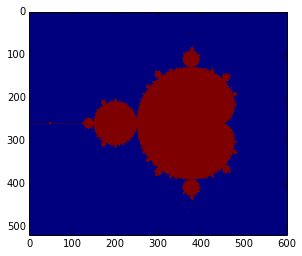

In [6]:
plt.imshow(np.abs(Z_out < 4))